# Task 1: DeezNode Sandwich Bot and Address Filter


In [ ]:
import pandas as pd
import re
import json
import numpy as np
import os
import json as json_lib

# #region agent log
log_path = '/Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/.cursor/debug.log'
try:
    with open(log_path, 'a') as f:
        f.write(json_lib.dumps({"id": "log_setup_start", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:setup", "message": "Starting notebook execution", "data": {"notebook": "01a_data_cleaning_DeezNode_filters"}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "A"}) + "\n")
except Exception as e:
    pass
# #endregion

# ───────────────────────────────────────────────
# SETUP: Define output directories
# ───────────────────────────────────────────────
notebook_dir = os.getcwd()
output_dir = os.path.join(notebook_dir, 'outputs')
csv_dir = os.path.join(output_dir, 'csv')
images_dir = os.path.join(output_dir, 'images')

os.makedirs(csv_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# #region agent log
try:
    with open(log_path, 'a') as f:
        f.write(json_lib.dumps({"id": "log_dir_setup", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:setup", "message": "Output directories created", "data": {"csv_dir": csv_dir, "images_dir": images_dir, "output_dir": output_dir, "exists_csv": os.path.exists(csv_dir), "exists_images": os.path.exists(images_dir)}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "A"}) + "\n")
except Exception as e:
    pass
# #endregion

print(f"Output directories created:")
print(f"  - CSV files: {csv_dir}")
print(f"  - Images: {images_dir}")
print(f"  - Other outputs: {output_dir}")

DATA_PATH = '/Users/aileen/Downloads/pamm/pamm_clean_final.parquet'
df = pd.read_parquet(DATA_PATH)

# #region agent log
try:
    with open(log_path, 'a') as f:
        f.write(json_lib.dumps({"id": "log_data_loaded", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:data_load", "message": "Data loaded", "data": {"rows": len(df), "columns": list(df.columns), "na_count": df.isna().sum().to_dict()}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "B"}) + "\n")
except Exception as e:
    pass
# #endregion

# Debug: Show data structure
print("="*60)
print("Task 1: DeezNode Detection - Data Overview")
print(f"Total rows: {len(df):,}")
print(f"Available columns: {list(df.columns)}")
if 'account_updates' in df.columns and len(df) > 0:
    sample = df['account_updates'].iloc[0]
    print(f"account_updates type: {type(sample)}")
    if hasattr(sample, '__len__') and len(sample) > 0:
        print(f"account_updates length: {len(sample)}")
        print(f"account_updates[0] type: {type(sample[0]) if hasattr(sample, '__getitem__') else 'N/A'}")
        print(f"account_updates sample: {str(sample)[:300]}")
print("="*60)
print()

def extract_addresses(row):
    # Handle already-parsed data (lists, numpy arrays, dicts) or strings
    addresses = []
    
    # Check if row is null/NaN - handle scalar and array cases
    if row is None:
        return []
    try:
        # For scalar values, pd.isna works fine
        if not isinstance(row, (list, dict, str, np.ndarray)):
            if pd.isna(row):
                return []
    except (ValueError, TypeError):
        # If pd.isna fails (e.g., for arrays), skip the check
        pass
    
    # Handle numpy arrays (common in parquet files)
    if isinstance(row, np.ndarray):
        row = row.tolist() if row.size > 0 else []
    
    # If already a list (or converted from numpy array), extract addresses directly
    if isinstance(row, list):
        for item in row:
            if isinstance(item, dict) and 'account' in item:
                addr = item.get('account', '')
                if addr and isinstance(addr, str):
                    addresses.append(addr)
            elif isinstance(item, str) and len(item) >= 32:
                # Direct address string in list
                addresses.append(item)
    
    # If already a dict, extract account
    elif isinstance(row, dict):
        if 'account' in row:
            addr = row.get('account', '')
            if addr and isinstance(addr, str):
                addresses.append(addr)
    
    # If string, try to parse or extract with regex
    elif isinstance(row, str):
        # Try to parse as JSON first
        try:
            cleaned = row.replace("'", '"').replace('None', 'null').replace('True', 'true').replace('False', 'false')
            parsed = json.loads(cleaned)
            if isinstance(parsed, list):
                for item in parsed:
                    if isinstance(item, dict) and 'account' in item:
                        addr = item.get('account', '')
                        if addr:
                            addresses.append(addr)
            elif isinstance(parsed, dict) and 'account' in parsed:
                addr = parsed.get('account', '')
                if addr:
                    addresses.append(addr)
        except (json.JSONDecodeError, ValueError, AttributeError):
            pass
        # Fallback to regex extraction
        if not addresses:
            addresses = re.findall(r'[A-Za-z0-9]{32,44}', row)
    
    return addresses

if 'account_updates' in df.columns:
    # Extract addresses - function handles already-parsed lists/dicts/numpy arrays or strings
    df['parsed_accounts'] = df['account_updates'].apply(extract_addresses)
    
    # Debug: Check extraction results
    total_addresses = sum(len(addr_list) for addr_list in df['parsed_accounts'])
    print(f"Extracted {total_addresses:,} total addresses from account_updates")
    if total_addresses > 0:
        # Show sample of extracted addresses
        sample_addresses = []
        for addr_list in df['parsed_accounts'].head(100):
            sample_addresses.extend(addr_list[:2])  # First 2 addresses from first 100 rows
        print(f"Sample addresses (first 10): {sample_addresses[:10]}")
    print()
else:
    df['parsed_accounts'] = [[] for _ in range(len(df))]

deez_bot_address = 'vpeNALD89BZ4KxNUFjdLmFXBCwtyqBDQ85ouNoax38b'
validator_address = 'HM5H6FAYWEMcm9PCXFbbiUFfFVLTN9UGy9AqmMQjdMRA'

print(f"Searching for DeezNode bot address: {deez_bot_address}")
print(f"Searching for DeezNode validator address: {validator_address}")
print()

# Build filter conditions: either bot address same OR validator address same
# Bot address can appear in: parsed_accounts, signer, or validator
bot_address_filter = df['parsed_accounts'].apply(lambda x: deez_bot_address in x if isinstance(x, list) else False)

if 'signer' in df.columns:
    signer_matches = (df['signer'] == deez_bot_address).sum()
    print(f"Signer (bot address) matches: {signer_matches}")
    bot_address_filter = bot_address_filter | (df['signer'] == deez_bot_address)
else:
    print("Signer column not found")

if 'validator' in df.columns:
    validator_bot_matches = (df['validator'] == deez_bot_address).sum()
    validator_val_matches = (df['validator'] == validator_address).sum()
    print(f"Validator (bot address) matches: {validator_bot_matches}")
    print(f"Validator (validator address) matches: {validator_val_matches}")
    bot_address_filter = bot_address_filter | (df['validator'] == deez_bot_address)
else:
    print("Validator column not found")

parsed_accounts_matches = df['parsed_accounts'].apply(lambda x: deez_bot_address in x if isinstance(x, list) else False).sum()
print(f"Parsed accounts (bot address) matches: {parsed_accounts_matches}")

# Validator address filter: check if validator column matches validator_address
if 'validator' in df.columns:
    validator_address_filter = (df['validator'] == validator_address)
else:
    validator_address_filter = pd.Series([False] * len(df), index=df.index)

# Combined filter: bot address same OR validator address same
deez_filter = bot_address_filter | validator_address_filter

print(f"\nTotal matches (bot address OR validator address): {deez_filter.sum()}")
print()

deez_matches = df[deez_filter].copy()

print("DeezNode Matches:")
if not deez_matches.empty:
    # Select only columns that exist
    available_cols = ['time', 'datetime', 'kind', 'amm', 'validator', 'signer', 'parsed_accounts']
    cols_to_show = [col for col in available_cols if col in deez_matches.columns]
    print(f"Found {len(deez_matches)} matches!")
    print(deez_matches[cols_to_show].head(10))
else:
    print("No matches found.")
    print("\nPossible reasons:")
    print("1. DeezNode bot is not active in this dataset time range")
    print("2. The address might be stored in a different format")
    print("3. The bot might be using different addresses")
    print("\nChecking for similar addresses...")
    # Check if any addresses are close matches
    if 'parsed_accounts' in df.columns:
        all_addresses = set()
        for addr_list in df['parsed_accounts']:
            all_addresses.update(addr_list)
        # Look for addresses starting with similar characters
        similar = [addr for addr in all_addresses if addr.startswith('vpe') or 'Deez' in str(addr).lower()]
        if similar:
            print(f"Found {len(similar)} addresses starting with 'vpe' or containing 'deez': {similar[:5]}")
        else:
            print("No similar addresses found.")

if not deez_matches.empty and 'validator' in df.columns and 'kind' in df.columns:
    deez_vals = deez_matches['validator'].unique()
    burst_trades = df[(df['validator'].isin(deez_vals)) & (df['kind'] == 'TRADE')]
    print(f"Potential bursts in DeezNode validators: {len(burst_trades)} TRADEs.")

print("\n" + "="*60)
print("MEV DETECTION: Analyzing Filtered Dataset for Sandwich Attacks")
print("="*60)
print("\nAnalyzing MEV patterns in filtered dataset (bot address OR validator address matches)...\n")

# ========== MEV DETECTION ON FILTERED DATASET ==========
# Initialize variables at top level to ensure they're accessible for saving
all_sandwiches = []
fat_sandwiches = []
validator_sandwich_counts = None
top_sandwich_validators = []
top_bots = []
validator_counts = None

# Use filtered dataset for MEV detection
mev_df = deez_matches if not deez_matches.empty else df
print(f"Analyzing {len(mev_df):,} rows for MEV patterns...\n")

# 1. Top Validators Analysis
if 'validator' in mev_df.columns and 'kind' in mev_df.columns:
    from collections import Counter
    
    # Get top validators by transaction count
    validator_counts = mev_df['validator'].value_counts()
    top_validators = validator_counts.head(20)
    
    print("Top 20 Validators by Transaction Volume (in filtered dataset):")
    for i, (validator, count) in enumerate(top_validators.items(), 1):
        print(f"  {i:2d}. {validator[:44]:44s} : {count:>10,} transactions")
    print()
    
    # Check for TRADE events
    trades_all = mev_df[mev_df['kind'] == 'TRADE'] if 'kind' in mev_df.columns else pd.DataFrame()
    
    if not trades_all.empty and 'validator' in trades_all.columns and 'signer' in trades_all.columns and 'time' in trades_all.columns:
        # 2. A-B-A Sandwich Pattern Detection Across All Validators
        print("Detecting A-B-A sandwich patterns across all validators...")
        all_sandwiches = []  # Reset for this analysis (already initialized above)
        
        grouped_by_validator = trades_all.groupby('validator')
        for validator, group in grouped_by_validator:
            if len(group) >= 3:
                # Sort by time to ensure chronological order
                group_sorted = group.sort_values('time')
                signers = group_sorted['signer'].tolist()
                
                # Detect A-B-A patterns
                for i in range(len(signers) - 2):
                    if signers[i] == signers[i+2] and signers[i] != signers[i+1]:
                        all_sandwiches.append({
                            'validator': validator,
                            'times': group_sorted.iloc[i:i+3]['time'].tolist(),
                            'signers': [signers[i], signers[i+1], signers[i+2]],
                            'bot_signer': signers[i],  # The attacker
                            'victim_signer': signers[i+1]  # The victim
                        })
        
        print(f"Found {len(all_sandwiches):,} A-B-A sandwich patterns across all validators\n")
        
        # ========== FAT SANDWICH DETECTION ACROSS MULTIPLE SLOTS ==========
        print("="*60)
        print("FAT SANDWICH MEV DETECTION: Multi-Slot Analysis")
        print("="*60)
        print("Detecting fat sandwiches (A-B-C-...-A patterns) across multiple slots...\n")
        
        fat_sandwiches = []  # Reset for this analysis (already initialized above)
        
        if 'slot' in trades_all.columns:
            # Group by validator and analyze across slots
            for validator, group in grouped_by_validator:
                if len(group) >= 3:
                    # Sort by slot first, then time
                    group_sorted = group.sort_values(['slot', 'time'])
                    signers = group_sorted['signer'].tolist()
                    slots = group_sorted['slot'].tolist()
                    times = group_sorted['time'].tolist()
                    
                    # Detect fat sandwiches: A-B-C-...-A patterns (same signer at start and end)
                    # Look for patterns where first and last signer match, with different signers in between
                    for i in range(len(signers) - 2):
                        bot_signer = signers[i]
                        # Look ahead for the same signer (closing the sandwich)
                        for j in range(i + 2, len(signers)):
                            if signers[j] == bot_signer:
                                # Found a sandwich: A-...-A
                                middle_signers = signers[i+1:j]
                                # Must have at least one different signer in the middle
                                if len(set(middle_signers)) > 0 and bot_signer not in middle_signers:
                                    slot_span = slots[j] - slots[i]
                                    time_span = times[j] - times[i]
                                    
                                    fat_sandwiches.append({
                                        'validator': validator,
                                        'bot_signer': bot_signer,
                                        'middle_signers': middle_signers,
                                        'victim_count': len(middle_signers),
                                        'slots': [slots[i], slots[j]],
                                        'slot_span': slot_span,
                                        'times': [times[i], times[j]],
                                        'time_span': time_span,
                                        'pattern': f"{bot_signer[:8]}...{len(middle_signers)} victims...{bot_signer[:8]}"
                                    })
                                break  # Found closing, move to next starting point
            
            print(f"Found {len(fat_sandwiches):,} fat sandwich patterns across multiple slots\n")
            
            if len(fat_sandwiches) > 0:
                # Analyze fat sandwiches
                multi_slot_sandwiches = [s for s in fat_sandwiches if s['slot_span'] > 0]
                single_slot_sandwiches = [s for s in fat_sandwiches if s['slot_span'] == 0]
                
                print(f"  - Multi-slot sandwiches: {len(multi_slot_sandwiches):,} ({len(multi_slot_sandwiches)/len(fat_sandwiches)*100:.1f}%)")
                print(f"  - Single-slot sandwiches: {len(single_slot_sandwiches):,} ({len(single_slot_sandwiches)/len(fat_sandwiches)*100:.1f}%)")
                print()
                
                # Top validators by fat sandwich count
                fat_validator_counts = Counter([s['validator'] for s in fat_sandwiches])
                top_fat_validators = fat_validator_counts.most_common(10)
                
                print("Top 10 Validators by Fat Sandwich Count:")
                for i, (validator, count) in enumerate(top_fat_validators, 1):
                    print(f"  {i:2d}. {validator[:44]:44s} : {count:>6,} fat sandwiches")
                print()
                
                # Fat sandwiches with most victims (most complex attacks)
                fat_sandwiches_sorted = sorted(fat_sandwiches, key=lambda x: x['victim_count'], reverse=True)
                print("Top 10 Fat Sandwiches by Victim Count (Most Complex Attacks):")
                for i, sandwich in enumerate(fat_sandwiches_sorted[:10], 1):
                    print(f"  {i:2d}. {sandwich['validator'][:30]:30s} | {sandwich['victim_count']:>3} victims | "
                          f"Slot span: {sandwich['slot_span']:>4} | Bot: {sandwich['bot_signer'][:20]}")
                print()
                
                # Multi-slot analysis
                if len(multi_slot_sandwiches) > 0:
                    max_slot_span = max(s['slot_span'] for s in multi_slot_sandwiches)
                    avg_slot_span = sum(s['slot_span'] for s in multi_slot_sandwiches) / len(multi_slot_sandwiches)
                    print(f"Multi-Slot Fat Sandwich Statistics:")
                    print(f"  - Maximum slot span: {max_slot_span} slots")
                    print(f"  - Average slot span: {avg_slot_span:.2f} slots")
                    print(f"  - Sandwiches spanning >5 slots: {sum(1 for s in multi_slot_sandwiches if s['slot_span'] > 5):,}")
                    print()
                
                # Sample fat sandwiches
                print("Sample Fat Sandwich Patterns:")
                for i, sandwich in enumerate(fat_sandwiches[:5], 1):
                    print(f"\n  Fat Sandwich {i}:")
                    print(f"    Validator: {sandwich['validator'][:44]}")
                    print(f"    Bot Signer: {sandwich['bot_signer'][:44]}")
                    print(f"    Victims: {sandwich['victim_count']} different signers")
                    print(f"    Slot Span: {sandwich['slot_span']} slots ({sandwich['slots'][0]} → {sandwich['slots'][1]})")
                    print(f"    Time Span: {sandwich['time_span']} seconds")
                    if len(sandwich['middle_signers']) <= 5:
                        print(f"    Middle Signers: {[s[:20] for s in sandwich['middle_signers']]}")
        else:
            print("⚠️  Cannot detect fat sandwiches: 'slot' column not found")
            print("   (Fat sandwich detection requires slot information)")
        
        print("\n" + "="*60)
        
        if len(all_sandwiches) > 0:
            # 3. Top Validators by Sandwich Activity
            validator_sandwich_counts = Counter([s['validator'] for s in all_sandwiches])
            top_sandwich_validators = validator_sandwich_counts.most_common(15)
            
            print("Top 15 Validators by Sandwich Pattern Count:")
            print("(These validators are processing the most MEV attacks)")
            for i, (validator, count) in enumerate(top_sandwich_validators, 1):
                validator_tx_count = validator_counts.get(validator, 0)
                sandwich_rate = (count / validator_tx_count * 100) if validator_tx_count > 0 else 0
                print(f"  {i:2d}. {validator[:44]:44s} : {count:>6,} sandwiches ({sandwich_rate:.2f}% of validator's transactions)")
            print()
            
            # 4. Most Active MEV Bot Signers
            bot_signer_counts = Counter([s['bot_signer'] for s in all_sandwiches])
            top_bots = bot_signer_counts.most_common(10)
            
            print("Top 10 Most Active MEV Bot Signers:")
            print("(These addresses are executing the most sandwich attacks)")
            for i, (bot, count) in enumerate(top_bots, 1):
                print(f"  {i:2d}. {bot[:44]:44s} : {count:>6,} sandwich attacks")
            print()
            
            # 5. Sample Sandwich Patterns from Top Validators
            print("Sample Sandwich Patterns (from top validators):")
            for i, sandwich in enumerate(all_sandwiches[:5], 1):
                print(f"\n  Pattern {i}:")
                print(f"    Validator: {sandwich['validator'][:44]}")
                print(f"    Bot Signer: {sandwich['bot_signer'][:44]}")
                print(f"    Victim Signer: {sandwich['victim_signer'][:44]}")
                print(f"    Times: {sandwich['times']}")
            
            # 6. Cross-reference with DeezNode search
            if not deez_matches.empty:
                deez_validators = set(deez_matches['validator'].unique())
                sandwich_validators = set([s['validator'] for s in all_sandwiches])
                overlap = deez_validators & sandwich_validators
                if overlap:
                    print(f"\n⚠️  Found {len(overlap)} validators that match DeezNode AND have sandwich patterns!")
                    print(f"   Overlapping validators: {list(overlap)[:5]}")
                else:
                    print("\nℹ️  No overlap between DeezNode matches and sandwich patterns")
                    print("   (MEV attacks are happening through other validators)")
        else:
            print("No A-B-A sandwich patterns detected across all validators.")
    else:
        print("Cannot analyze sandwich patterns: missing required columns (validator, signer, time, kind)")
else:
    print("Cannot analyze validators: missing 'validator' or 'kind' column")

print("\n" + "="*60)
print("KEY INSIGHTS (Filtered Dataset Analysis):")
print("="*60)
print(f"1. Analyzing {len(mev_df):,} rows filtered by: bot address OR validator address matches")
print("2. MEV attacks detected in transactions involving DeezNode bot or validator")
print("3. A-B-A patterns indicate sandwich attacks in the filtered dataset")
print("4. Fat sandwiches (A-B-C-...-A) can span multiple slots and target multiple victims")
print("5. Multi-slot fat sandwiches indicate sophisticated, coordinated MEV attacks")
print("6. High sandwich rates suggest MEV bot coordination in filtered transactions")
print("="*60)

print("\nInference: If TRADE events dominate with high us_since_first_shred (>300ms), indicates front-running. Check for A-B-A patterns in same validator for sandwiches.")

# #region agent log
try:
    with open(log_path, 'a') as f:
        f.write(json_lib.dumps({"id": "log_analysis_complete", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:end", "message": "Analysis complete, checking what to save", "data": {"all_sandwiches_count": len(all_sandwiches), "fat_sandwiches_count": len(fat_sandwiches), "deez_matches_count": len(deez_matches) if 'deez_matches' in locals() else 0}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "C"}) + "\n")
except Exception as e:
    pass
# #endregion

# #endregion

Output directories created:
  - CSV files: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv
  - Images: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images
  - Other outputs: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs


Task 1: DeezNode Detection - Data Overview
Total rows: 5,506,090
Available columns: ['slot', 'time', 'validator', 'tx_idx', 'sig', 'signer', 'kind', 'amm_oracle', 'account_updates', 'trades', 'us_since_first_shred', 'amm_trade', 'account_trade', 'is_pool_trade', 'bytes_changed_trade', 'datetime', 'timing_missing', 'ms_time']
account_updates type: <class 'numpy.ndarray'>
account_updates length: 1
account_updates[0] type: <class 'dict'>
account_updates sample: [{'account': 'ELp3rjbAncW8FLAPvmWS6vjG4FXFLDo1HiKh4PhQBgvx', 'amm_name': 'HumidiFi', 'bytes_changed': 6, 'is_pool': True}]



Extracted 5,892,841 total addresses from account_updates
Sample addresses (first 10): ['ELp3rjbAncW8FLAPvmWS6vjG4FXFLDo1HiKh4PhQBgvx', '2866MvCKPGz9LdnPcmPueoV3mA2Ac1ceEQ8Xqb9VNefu', 'AvGeFw71N5sNfV97mZ1uNrHg4yfufRicCJUrS9j2ehTX', 'DB3sUCP2H4icbeKmK6yb6nUxU5ogbcRHtGuq7W2RoRwW', 'Cc2oMdeNDmZ7ZD8b7igQg1EHjBEinR1Vi6nx2VHpVm6H', 'FksffEqnBRixYGR791Qw2MgdU7zNCpHVFYBL4Fa4qVuH', '3QYYvFWgSuGK8bbxMSAYkCqE8QfSuFtByagnZAuekia2', 'H3chk8rgniKXnToGTdPUFieuHGLQQfBMXVbGp6bR1uMD', '51FQwjrvo8J8zXUaKyAznJ5NYpoiTCuqAqCu3HAMB9NZ', '6N8CvQP3KMQ7poeyLg948CMetR8nSto3e4eaGQYc6PdS']

Searching for DeezNode bot address: vpeNALD89BZ4KxNUFjdLmFXBCwtyqBDQ85ouNoax38b
Searching for DeezNode validator address: HM5H6FAYWEMcm9PCXFbbiUFfFVLTN9UGy9AqmMQjdMRA



Signer (bot address) matches: 0
Validator (bot address) matches: 0
Validator (validator address) matches: 0


Parsed accounts (bot address) matches: 0

Total matches (bot address OR validator address): 0



DeezNode Matches:
No matches found.

Possible reasons:
1. DeezNode bot is not active in this dataset time range
2. The address might be stored in a different format
3. The bot might be using different addresses

Checking for similar addresses...


No similar addresses found.

MEV DETECTION: Analyzing Filtered Dataset for Sandwich Attacks

Analyzing MEV patterns in filtered dataset (bot address OR validator address matches)...

Analyzing 5,506,090 rows for MEV patterns...

Top 20 Validators by Transaction Volume (in filtered dataset):
   1. HEL1USMZKAL2odpNBj2oCjffnFGaYwmbGmyewGv1e2TU :    210,852 transactions
   2. DRpbCBMxVnDK7maPM5tGv6MvB3v1sRMC86PZ8okm21hy :    198,106 transactions
   3. Fd7btgySsrjuo25CJCj7oE7VPMyezDhnx7pZkj2v69Nk :    146,596 transactions
   4. JupmVLmA8RoyTUbTMMuTtoPWHEiNQobxgTeGTrPNkzT  :    135,318 transactions
   5. q9XWcZ7T1wP4bW9SB4XgNNwjnFEJ982nE8aVbbNuwot  :    118,664 transactions
   6. 5pPRHniefFjkiaArbGX3Y8NUysJmQ9tMZg3FrFGwHzSm :    115,421 transactions
   7. DtdSSG8ZJRZVv5Jx7K1MeWp7Zxcu19GD5wQRGRpQ9uMF :     99,183 transactions
   8. JD549HsbJHeEKKUrKgg4Fj2iyv2RGjsV7NTZjZUrHybB :     94,233 transactions
   9. 9jxgosAfHgHzwnxsHw4RAZYaLVokMbnYtmiZBreynGFP :     82,773 transactions
  10. Awes4Tr6T

Detecting A-B-A sandwich patterns across all validators...


Found 24,215 A-B-A sandwich patterns across all validators

FAT SANDWICH MEV DETECTION: Multi-Slot Analysis
Detecting fat sandwiches (A-B-C-...-A patterns) across multiple slots...



Found 367,162 fat sandwich patterns across multiple slots

  - Multi-slot sandwiches: 303,926 (82.8%)
  - Single-slot sandwiches: 63,236 (17.2%)

Top 10 Validators by Fat Sandwich Count:
   1. HEL1USMZKAL2odpNBj2oCjffnFGaYwmbGmyewGv1e2TU : 20,100 fat sandwiches
   2. DRpbCBMxVnDK7maPM5tGv6MvB3v1sRMC86PZ8okm21hy : 16,222 fat sandwiches
   3. Fd7btgySsrjuo25CJCj7oE7VPMyezDhnx7pZkj2v69Nk : 11,942 fat sandwiches
   4. 5pPRHniefFjkiaArbGX3Y8NUysJmQ9tMZg3FrFGwHzSm : 10,262 fat sandwiches
   5. q9XWcZ7T1wP4bW9SB4XgNNwjnFEJ982nE8aVbbNuwot  :  9,260 fat sandwiches
   6. DtdSSG8ZJRZVv5Jx7K1MeWp7Zxcu19GD5wQRGRpQ9uMF :  8,842 fat sandwiches
   7. JD549HsbJHeEKKUrKgg4Fj2iyv2RGjsV7NTZjZUrHybB :  8,029 fat sandwiches
   8. JupmVLmA8RoyTUbTMMuTtoPWHEiNQobxgTeGTrPNkzT  :  7,851 fat sandwiches
   9. 9jxgosAfHgHzwnxsHw4RAZYaLVokMbnYtmiZBreynGFP :  6,939 fat sandwiches
  10. Awes4Tr6TX8JDzEhCZY2QVNimT6iD1zWHzf1vNyGvpLM :  6,590 fat sandwiches

Top 10 Fat Sandwiches by Victim Count (Most Complex Attacks):


In [ ]:
# ───────────────────────────────────────────────
# SAVE RESULTS TO CSV FILES
# ───────────────────────────────────────────────
# This cell saves all analysis results to CSV files in outputs/csv/
# Run this cell after Cell 1 completes to ensure all data is saved

print("\n" + "="*60)
print("SAVING RESULTS TO CSV FILES")
print("="*60)
print("THIS MESSAGE CONFIRMS THE SAVE CODE IS EXECUTING")

# Ensure directories exist
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)
print(f"DEBUG: Ensured directories exist")

# Debug: Print variable states
print(f"DEBUG: all_sandwiches length: {len(all_sandwiches)}")
print(f"DEBUG: fat_sandwiches length: {len(fat_sandwiches)}")
print(f"DEBUG: validator_counts is None: {validator_counts is None}")
print(f"DEBUG: csv_dir exists: {os.path.exists(csv_dir)}")
print(f"DEBUG: csv_dir path: {csv_dir}")
print(f"DEBUG: csv_dir absolute path: {os.path.abspath(csv_dir)}")

# #region agent log
try:
    with open(log_path, 'a') as f:
        f.write(json_lib.dumps({"id": "log_save_start", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:save_start", "message": "Starting save operations", "data": {"all_sandwiches_len": len(all_sandwiches), "fat_sandwiches_len": len(fat_sandwiches), "csv_dir": csv_dir, "csv_dir_exists": os.path.exists(csv_dir), "images_dir": images_dir, "images_dir_exists": os.path.exists(images_dir)}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "H"}) + "\n")
except Exception as e:
    print(f"DEBUG: Logging error: {e}")

# #endregion

# Save sandwich patterns
print(f"DEBUG: Attempting to save sandwich patterns. Count: {len(all_sandwiches)}")
try:
    if len(all_sandwiches) > 0:
        print(f"DEBUG: Creating DataFrame from {len(all_sandwiches)} sandwiches...")
        sandwiches_df = pd.DataFrame(all_sandwiches)
        sandwiches_csv_path = os.path.join(csv_dir, 'sandwich_patterns.csv')
        print(f"DEBUG: Saving to: {sandwiches_csv_path}")
        print(f"DEBUG: Absolute path: {os.path.abspath(sandwiches_csv_path)}")
        try:
            sandwiches_df.to_csv(sandwiches_csv_path, index=False)
            if os.path.exists(sandwiches_csv_path):
                file_size = os.path.getsize(sandwiches_csv_path)
                print(f"✓ Saved {len(sandwiches_df):,} sandwich patterns to: {sandwiches_csv_path}")
                print(f"DEBUG: File exists after save: True, size: {file_size} bytes")
            else:
                print(f"ERROR: File was not created at {sandwiches_csv_path}")
        except Exception as save_error:
            print(f"ERROR during to_csv(): {save_error}")
            import traceback
            traceback.print_exc()
            raise
        
        # #region agent log
        try:
            with open(log_path, 'a') as f:
                f.write(json_lib.dumps({"id": "log_csv_saved", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:save_csv", "message": "Sandwich patterns CSV saved", "data": {"file": sandwiches_csv_path, "rows": len(sandwiches_df), "file_exists": os.path.exists(sandwiches_csv_path)}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "D"}) + "\n")
        except Exception as e:
            pass
        # #endregion
    else:
        print("⚠ No sandwich patterns to save")
except Exception as e:
    print(f"ERROR saving sandwich patterns: {e}")
    import traceback
    traceback.print_exc()

# Save fat sandwiches
try:
    if len(fat_sandwiches) > 0:
        fat_sandwiches_df = pd.DataFrame(fat_sandwiches)
        fat_sandwiches_csv_path = os.path.join(csv_dir, 'fat_sandwich_patterns.csv')
        fat_sandwiches_df.to_csv(fat_sandwiches_csv_path, index=False)
        print(f"✓ Saved {len(fat_sandwiches_df):,} fat sandwich patterns to: {fat_sandwiches_csv_path}")
        
        # #region agent log
        try:
            with open(log_path, 'a') as f:
                f.write(json_lib.dumps({"id": "log_csv_saved", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:save_csv", "message": "Fat sandwich patterns CSV saved", "data": {"file": fat_sandwiches_csv_path, "rows": len(fat_sandwiches_df), "file_exists": os.path.exists(fat_sandwiches_csv_path)}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "D"}) + "\n")
        except Exception as e:
            pass
        # #endregion
    else:
        print("⚠ No fat sandwich patterns to save")
except Exception as e:
    print(f"ERROR saving fat sandwiches: {e}")
    import traceback
    traceback.print_exc()

# Save DeezNode matches
try:
    if 'deez_matches' in locals() and not deez_matches.empty:
        deez_csv_path = os.path.join(csv_dir, 'deeznode_matches.csv')
        deez_matches.to_csv(deez_csv_path, index=False)
        print(f"✓ Saved {len(deez_matches):,} DeezNode matches to: {deez_csv_path}")
    else:
        print("⚠ No DeezNode matches to save")
except Exception as e:
    print(f"ERROR saving DeezNode matches: {e}")
    import traceback
    traceback.print_exc()

# Save top validators analysis
try:
    if validator_counts is not None:
        top_validators_df = pd.DataFrame({
            'validator': validator_counts.index,
            'transaction_count': validator_counts.values
        }).head(20)
        top_validators_csv_path = os.path.join(csv_dir, 'top_validators_by_volume.csv')
        top_validators_df.to_csv(top_validators_csv_path, index=False)
        print(f"✓ Saved top 20 validators to: {top_validators_csv_path}")
except Exception as e:
    print(f"ERROR saving top validators: {e}")
    import traceback
    traceback.print_exc()

# Save top sandwich validators
try:
    if validator_sandwich_counts is not None and len(top_sandwich_validators) > 0:
        top_sandwich_validators_df = pd.DataFrame({
            'validator': [v[0] for v in top_sandwich_validators],
            'sandwich_count': [v[1] for v in top_sandwich_validators]
        })
        top_sandwich_validators_csv_path = os.path.join(csv_dir, 'top_validators_by_sandwich_count.csv')
        top_sandwich_validators_df.to_csv(top_sandwich_validators_csv_path, index=False)
        print(f"✓ Saved top sandwich validators to: {top_sandwich_validators_csv_path}")
except Exception as e:
    print(f"ERROR saving top sandwich validators: {e}")
    import traceback
    traceback.print_exc()

# Save top MEV bot signers
try:
    if len(top_bots) > 0:
        top_bots_df = pd.DataFrame({
            'bot_signer': [b[0] for b in top_bots],
            'sandwich_attack_count': [b[1] for b in top_bots]
        })
        top_bots_csv_path = os.path.join(csv_dir, 'top_mev_bot_signers.csv')
        top_bots_df.to_csv(top_bots_csv_path, index=False)
        print(f"✓ Saved top MEV bot signers to: {top_bots_csv_path}")
except Exception as e:
    print(f"ERROR saving top MEV bot signers: {e}")
    import traceback
    traceback.print_exc()

# Check for NA values and save dropped rows
try:
    if df.isna().any().any():
        na_summary = df.isna().sum()
        na_summary_df = pd.DataFrame({
            'column': na_summary.index,
            'missing_count': na_summary.values,
            'missing_percentage': (na_summary.values / len(df) * 100).round(2)
        }).sort_values('missing_count', ascending=False)
        na_summary_csv_path = os.path.join(csv_dir, 'missing_values_summary.csv')
        na_summary_df.to_csv(na_summary_csv_path, index=False)
        print(f"✓ Saved missing values summary to: {na_summary_csv_path}")
        
        # Save rows with any NA values (if user wants to review dropped data)
        rows_with_na = df[df.isna().any(axis=1)]
        if len(rows_with_na) > 0:
            na_rows_csv_path = os.path.join(csv_dir, 'rows_with_missing_values.csv')
            rows_with_na.to_csv(na_rows_csv_path, index=False)
            print(f"✓ Saved {len(rows_with_na):,} rows with missing values to: {na_rows_csv_path}")
            
            # #region agent log
            try:
                with open(log_path, 'a') as f:
                    f.write(json_lib.dumps({"id": "log_na_rows_saved", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:save_na", "message": "Rows with NA values saved", "data": {"file": na_rows_csv_path, "rows": len(rows_with_na), "file_exists": os.path.exists(na_rows_csv_path)}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "E"}) + "\n")
            except Exception as e:
                pass
            # #endregion
except Exception as e:
    print(f"ERROR saving NA values: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("Save operations completed!")
print("="*60)

# Final verification
print(f"\nFINAL CHECK:")
print(f"  - CSV directory: {csv_dir}")
print(f"  - CSV directory exists: {os.path.exists(csv_dir)}")
if os.path.exists(csv_dir):
    csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]
    print(f"  - CSV files created: {len(csv_files)}")
    if csv_files:
        print(f"  - Files: {csv_files}")
    else:
        print(f"  - WARNING: No CSV files found in {csv_dir}")
else:
    print(f"  - ERROR: CSV directory does not exist!")


SAVING RESULTS TO CSV FILES
THIS MESSAGE CONFIRMS THE SAVE CODE IS EXECUTING
DEBUG: Ensured directories exist
DEBUG: all_sandwiches length: 24215
DEBUG: fat_sandwiches length: 367162
DEBUG: validator_counts is None: False
DEBUG: csv_dir exists: True
DEBUG: csv_dir path: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv
DEBUG: csv_dir absolute path: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv
DEBUG: Attempting to save sandwich patterns. Count: 24215
DEBUG: Creating DataFrame from 24215 sandwiches...


DEBUG: Saving to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/sandwich_patterns.csv
DEBUG: Absolute path: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/sandwich_patterns.csv
✓ Saved 24,215 sandwich patterns to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/sandwich_patterns.csv
DEBUG: File exists after save: True, size: 7729445 bytes


✓ Saved 367,162 fat sandwich patterns to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/fat_sandwich_patterns.csv
⚠ No DeezNode matches to save
✓ Saved top 20 validators to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/top_validators_by_volume.csv
✓ Saved top sandwich validators to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/top_validators_by_sandwich_count.csv
✓ Saved top MEV bot signers to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/top_mev_bot_signers.csv


✓ Saved missing values summary to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/missing_values_summary.csv


✓ Saved 5,506,090 rows with missing values to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv/rows_with_missing_values.csv

Save operations completed!

FINAL CHECK:
  - CSV directory: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/csv
  - CSV directory exists: True
  - CSV files created: 7
  - Files: ['sandwich_patterns.csv', 'top_mev_bot_signers.csv', 'fat_sandwich_patterns.csv', 'top_validators_by_sandwich_count.csv', 'missing_values_summary.csv', 'top_validators_by_volume.csv', 'rows_with_missing_values.csv']


CREATING VISUALIZATIONS


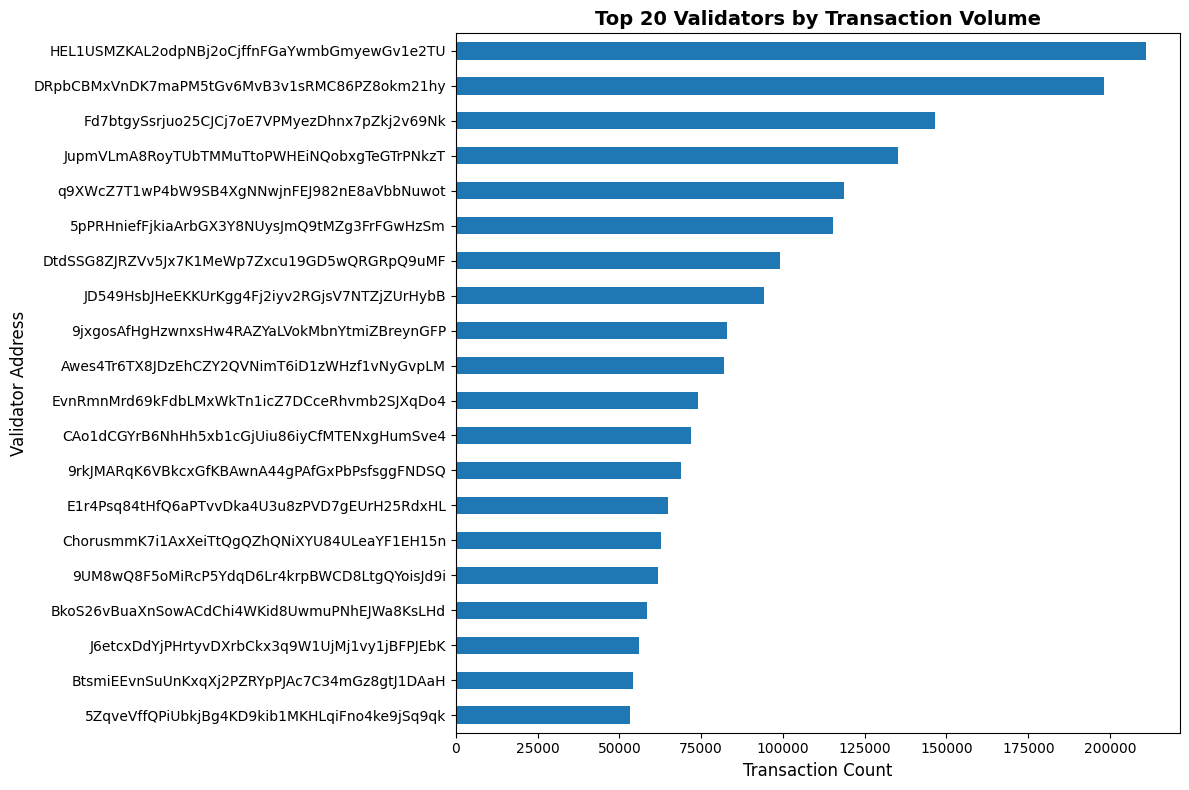

✓ Saved top validators chart to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images/top_validators_by_volume.png


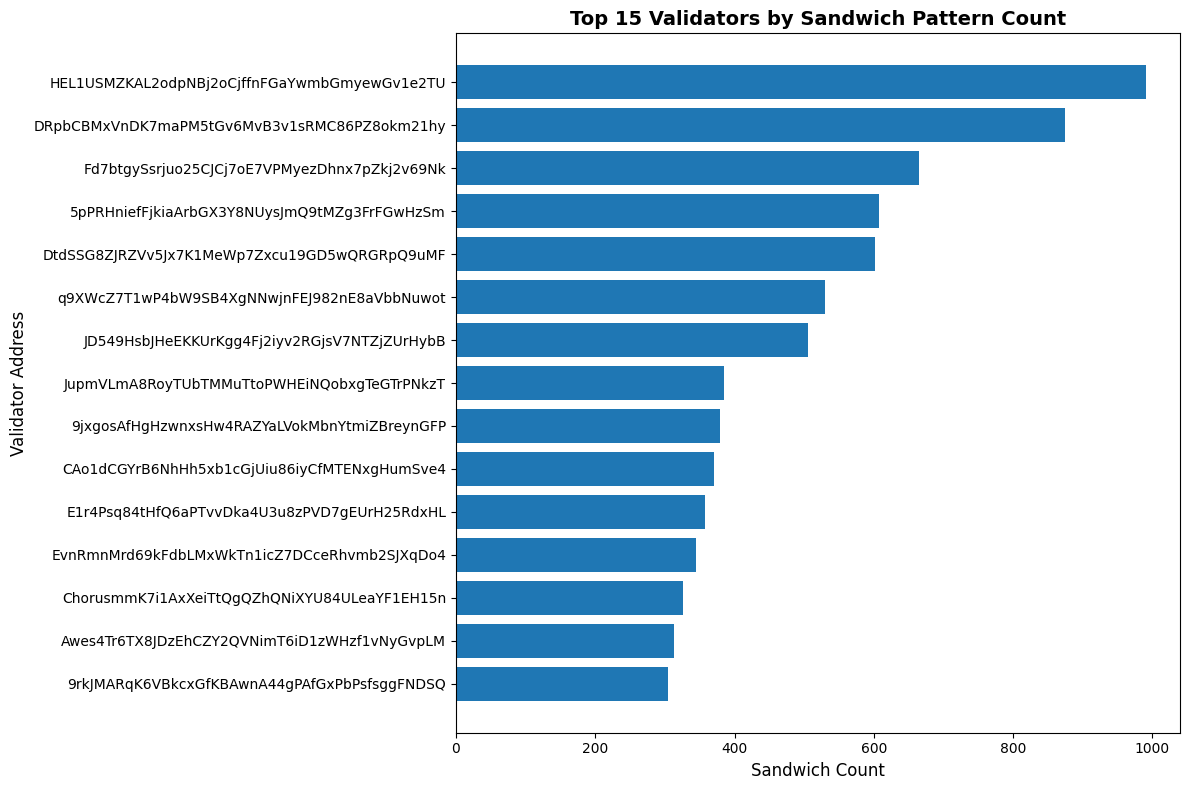

✓ Saved top sandwich validators chart to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images/top_validators_by_sandwich_count.png


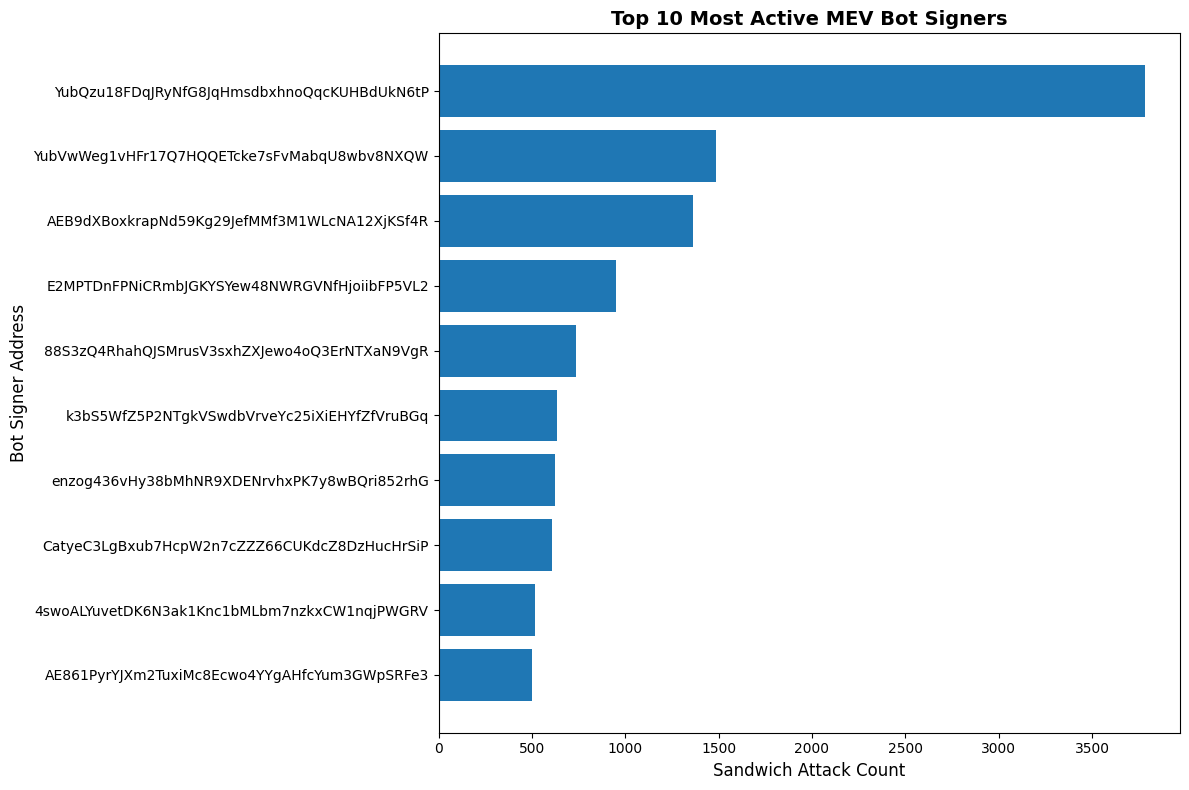

✓ Saved top MEV bot signers chart to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images/top_mev_bot_signers.png


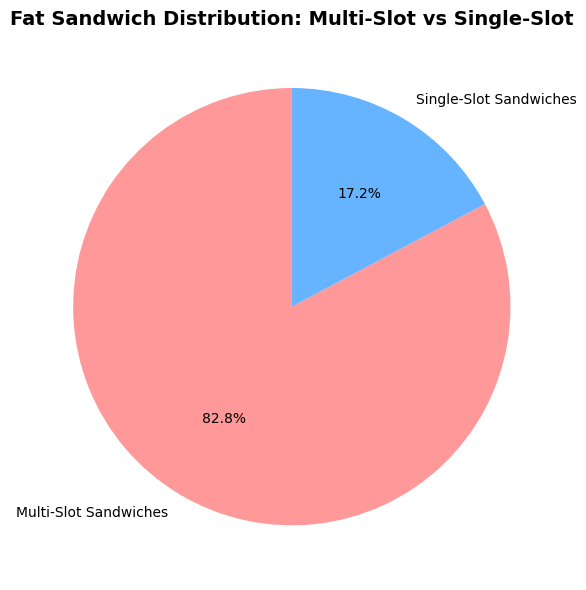

✓ Saved fat sandwich distribution chart to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images/fat_sandwich_distribution.png


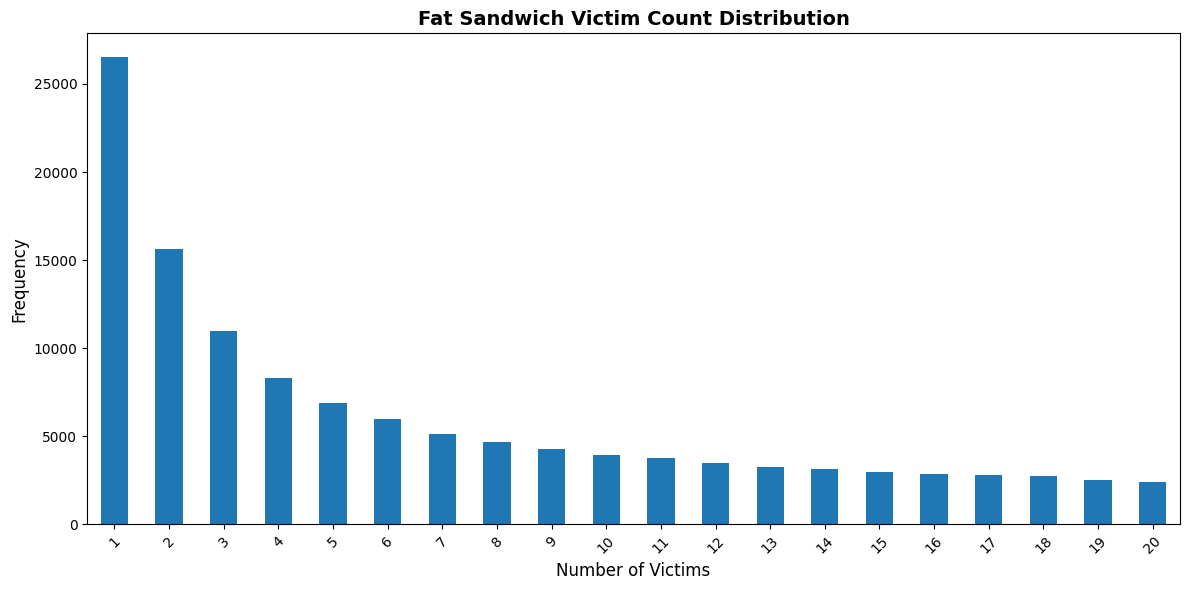

✓ Saved victim count distribution chart to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images/fat_sandwich_victim_distribution.png


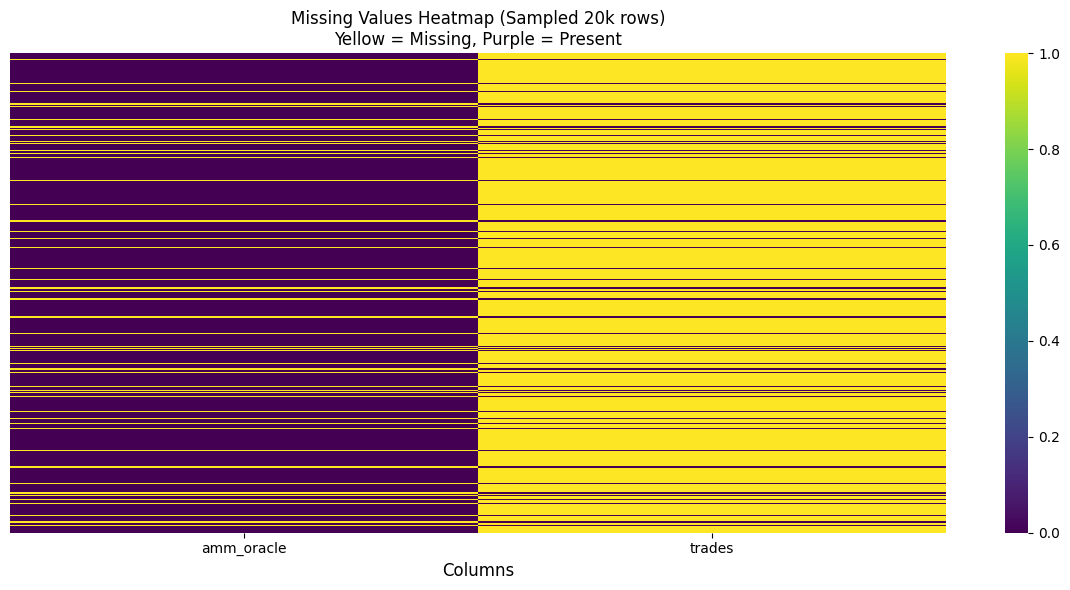

✓ Saved missing values heatmap to: /Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01a_data_cleaning_DeezNode_filters/outputs/images/missing_values_heatmap.png

All visualizations saved successfully!


In [3]:
# ───────────────────────────────────────────────
# CREATE AND SAVE VISUALIZATIONS
# ───────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

print("="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# #region agent log
try:
    with open(log_path, 'a') as f:
        f.write(json_lib.dumps({"id": "log_viz_start", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:viz", "message": "Starting visualization creation", "data": {}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "F"}) + "\n")
except Exception as e:
    pass
# #endregion

# 1. Top Validators Bar Chart
if validator_counts is not None:
    plt.figure(figsize=(12, 8))
    top_20 = validator_counts.head(20)
    top_20.plot(kind='barh')
    plt.title('Top 20 Validators by Transaction Volume', fontsize=14, fontweight='bold')
    plt.xlabel('Transaction Count', fontsize=12)
    plt.ylabel('Validator Address', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    validators_chart_path = os.path.join(images_dir, 'top_validators_by_volume.png')
    plt.savefig(validators_chart_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved top validators chart to: {validators_chart_path}")
    
    # #region agent log
    try:
        with open(log_path, 'a') as f:
            f.write(json_lib.dumps({"id": "log_viz_saved", "timestamp": pd.Timestamp.now().timestamp() * 1000, "location": "01a_data_cleaning_DeezNode_filters.ipynb:viz", "message": "Top validators chart saved", "data": {"file": validators_chart_path, "file_exists": os.path.exists(validators_chart_path)}, "sessionId": "debug-session", "runId": "run1", "hypothesisId": "F"}) + "\n")
    except Exception as e:
        pass
    # #endregion

# 2. Top Sandwich Validators Chart
if validator_sandwich_counts is not None and len(validator_sandwich_counts) > 0:
    plt.figure(figsize=(12, 8))
    top_15_sandwich = dict(validator_sandwich_counts.most_common(15))
    plt.barh(range(len(top_15_sandwich)), list(top_15_sandwich.values()))
    plt.yticks(range(len(top_15_sandwich)), [v[:44] for v in top_15_sandwich.keys()])
    plt.title('Top 15 Validators by Sandwich Pattern Count', fontsize=14, fontweight='bold')
    plt.xlabel('Sandwich Count', fontsize=12)
    plt.ylabel('Validator Address', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    sandwich_validators_chart_path = os.path.join(images_dir, 'top_validators_by_sandwich_count.png')
    plt.savefig(sandwich_validators_chart_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved top sandwich validators chart to: {sandwich_validators_chart_path}")

# 3. Top MEV Bot Signers Chart
if len(top_bots) > 0:
    plt.figure(figsize=(12, 8))
    bot_addresses = [b[0] for b in top_bots]
    bot_counts = [b[1] for b in top_bots]
    plt.barh(range(len(bot_addresses)), bot_counts)
    plt.yticks(range(len(bot_addresses)), [addr[:44] for addr in bot_addresses])
    plt.title('Top 10 Most Active MEV Bot Signers', fontsize=14, fontweight='bold')
    plt.xlabel('Sandwich Attack Count', fontsize=12)
    plt.ylabel('Bot Signer Address', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    top_bots_chart_path = os.path.join(images_dir, 'top_mev_bot_signers.png')
    plt.savefig(top_bots_chart_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved top MEV bot signers chart to: {top_bots_chart_path}")

# 4. Fat Sandwich Analysis Chart
if len(fat_sandwiches) > 0:
    fat_sandwiches_df = pd.DataFrame(fat_sandwiches)
    
    # Multi-slot vs Single-slot distribution
    multi_slot_count = len([s for s in fat_sandwiches if s['slot_span'] > 0])
    single_slot_count = len([s for s in fat_sandwiches if s['slot_span'] == 0])
    
    plt.figure(figsize=(10, 6))
    plt.pie([multi_slot_count, single_slot_count], 
            labels=['Multi-Slot Sandwiches', 'Single-Slot Sandwiches'],
            autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
    plt.title('Fat Sandwich Distribution: Multi-Slot vs Single-Slot', fontsize=14, fontweight='bold')
    plt.tight_layout()
    fat_sandwich_dist_path = os.path.join(images_dir, 'fat_sandwich_distribution.png')
    plt.savefig(fat_sandwich_dist_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved fat sandwich distribution chart to: {fat_sandwich_dist_path}")
    
    # Victim count distribution
    if 'victim_count' in fat_sandwiches_df.columns:
        plt.figure(figsize=(12, 6))
        victim_counts = fat_sandwiches_df['victim_count'].value_counts().sort_index().head(20)
        victim_counts.plot(kind='bar')
        plt.title('Fat Sandwich Victim Count Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Victims', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        victim_dist_path = os.path.join(images_dir, 'fat_sandwich_victim_distribution.png')
        plt.savefig(victim_dist_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved victim count distribution chart to: {victim_dist_path}")

# 5. Missing Values Heatmap (if there are NA values)
if df.isna().any().any():
    na_cols = df.columns[df.isna().any()].tolist()
    if len(na_cols) > 0:
        # Sample data for heatmap (for performance)
        sample_size = min(20000, len(df))
        sample_df = df[na_cols].sample(n=sample_size, random_state=42)
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(sample_df.isna(), cbar=True, cmap='viridis', yticklabels=False, linewidths=0)
        plt.title('Missing Values Heatmap (Sampled 20k rows)\nYellow = Missing, Purple = Present', fontsize=12)
        plt.xlabel('Columns', fontsize=12)
        plt.tight_layout()
        na_heatmap_path = os.path.join(images_dir, 'missing_values_heatmap.png')
        plt.savefig(na_heatmap_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved missing values heatmap to: {na_heatmap_path}")

print("\n" + "="*60)
print("All visualizations saved successfully!")
print("="*60)